# Exploratory Data Analysis
<a id='eda'></a>

In [1]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

## Importing and Cleaning
<a id='imp'></a>

In [2]:
"""
Load historical price data
"""
btc_df = pd.read_csv('../data/raw/btc_price.csv').drop('Unnamed: 0', axis=1)
btc_df = btc_df.set_index('date')
btc_df.index = pd.to_datetime(btc_df.index)
btc_df = btc_df.reindex(index=btc_df.index[::-1])
btc_df.head()

,open,high,low,close,volume,marketcap
date,,,,,,
2014-01-01,754.97,775.35,754.97,771.40,22489400,9403308145
2014-01-02,773.44,820.31,767.21,802.39,38489500,9781073921
2014-01-03,802.85,834.15,789.12,818.72,37810100,9980135396
2014-01-04,823.27,859.51,801.67,859.51,38005000,10477362437
2014-01-05,858.55,952.40,854.52,933.53,72898496,11379660685


In [3]:
"""
Load Google trend data
"""
trend_df = pd.read_csv('../data/raw/btc_trend.csv').drop('Unnamed: 0', axis=1)
trend_df = trend_df.set_index('date')
trend_df = trend_df.reindex(index=trend_df.index[::-1])
trend_df.columns = ['trend']
trend_df.head()

,trend
date,
2014-01-01,3.101767
2014-01-02,3.506346
2014-01-03,3.910924
2014-01-04,3.371486
2014-01-05,3.641205


In [4]:
"""
Check info
"""
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2014-01-01 to 2019-10-07
Data columns (total 6 columns):
open         2106 non-null float64
high         2106 non-null float64
low          2106 non-null float64
close        2106 non-null float64
volume       2106 non-null int64
marketcap    2106 non-null int64
dtypes: float64(4), int64(2)
memory usage: 115.2 KB


In [5]:
"""
Check info
"""
trend_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2105 entries, 2014-01-01 to 2019-10-06
Data columns (total 1 columns):
trend    2105 non-null float64
dtypes: float64(1)
memory usage: 32.9+ KB


In [6]:
"""
Merge dataframes
"""
btc_df = btc_df.merge(trend_df, left_index=True, right_index=True)
btc_df.head()

,open,high,low,close,volume,marketcap,trend
date,,,,,,,
2014-01-01,754.97,775.35,754.97,771.40,22489400,9403308145,3.101767
2014-01-02,773.44,820.31,767.21,802.39,38489500,9781073921,3.506346
2014-01-03,802.85,834.15,789.12,818.72,37810100,9980135396,3.910924
2014-01-04,823.27,859.51,801.67,859.51,38005000,10477362437,3.371486
2014-01-05,858.55,952.40,854.52,933.53,72898496,11379660685,3.641205


In [7]:
"""
Check descriptive stats for possible outliers
"""
btc_df.describe()

,open,high,low,close,volume,marketcap,trend
count,2105.000000,2105.000000,2105.000000,2105.000000,2.105000e+03,2.105000e+03,2105.000000
mean,3197.072010,3286.501986,3099.316917,3200.414185,3.523629e+09,5.432155e+10,5.559856
std,3812.437143,3941.602465,3658.917135,3813.437968,6.127481e+09,6.615433e+10,8.010420
min,176.900000,211.730000,171.510000,178.100000,2.857830e+06,2.444379e+09,0.921315
25%,423.620000,429.770000,418.480000,423.410000,3.227500e+07,6.201590e+09,1.502398
50%,795.990000,823.310000,780.000000,800.880000,1.218870e+08,1.182790e+10,2.832048
75%,6114.850000,6255.710000,5965.070000,6153.850000,4.788260e+09,1.054036e+11,6.849382
max,19475.800000,20089.000000,18974.100000,19497.400000,4.510573e+10,3.265025e+11,100.000000


In [8]:
"""
Max trend value is far from the mean, possible outlier
"""
btc_df[btc_df.trend == btc_df.trend.max()]

,open,high,low,close,volume,marketcap,trend
date,,,,,,,
2017-12-22,15898.0,15943.4,11833.0,13831.8,22197999616,231788283457,100.0


In [9]:
"""
Check associated values
"""
btc_df['2017-12-20':'2017-12-24']

,open,high,low,close,volume,marketcap,trend
date,,,,,,,
2017-12-20,17760.3,17934.7,16077.7,16624.6,22149699584,278528964015,70.0
2017-12-21,16642.4,17567.7,15342.7,15802.9,16516599808,264788651530,53.0
2017-12-22,15898.0,15943.4,11833.0,13831.8,22197999616,231788283457,100.0
2017-12-23,13948.7,15603.2,13828.8,14699.2,13086000128,246349213910,63.0
2017-12-24,14608.2,14626.0,12747.7,13925.8,11572299776,233414163395,48.0


This trend value point doesn't seem like an outlier and the range of values for the rest of the features seem reasonable.

## Visualization
<a id='viz'></a>

Check time series and value counts for close and trend values.

D:\Programs\Anaconda\envs\capstone\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


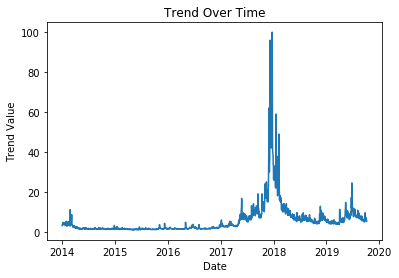

In [10]:
plt.plot(btc_df.trend)
plt.title('Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Trend Value')
plt.show()

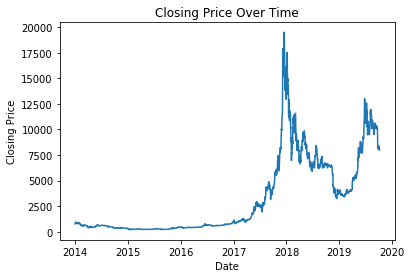

In [11]:
plt.plot(btc_df.close)
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

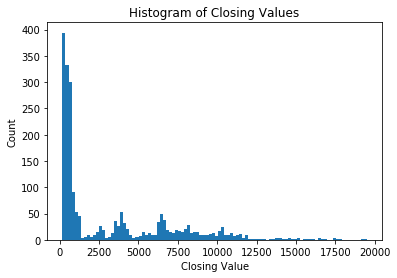

In [12]:
plt.hist(btc_df.close, bins = 100)
plt.title('Histogram of Closing Values')
plt.xlabel('Closing Value')
plt.ylabel('Count')
plt.show()

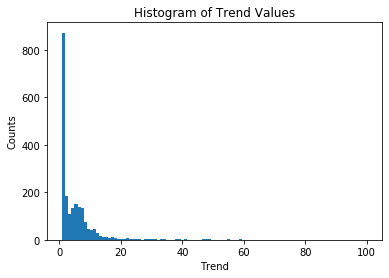

In [13]:
plt.hist(btc_df.trend, bins=100)
plt.title('Histogram of Trend Values')
plt.xlabel('Trend')
plt.ylabel('Counts')
plt.show()

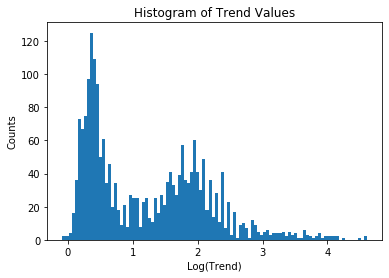

In [14]:
#log transform for better visualization
plt.hist(np.log(btc_df.trend), bins=100)
plt.title('Histogram of Trend Values')
plt.xlabel('Log(Trend)')
plt.ylabel('Counts')
plt.show()

In [15]:
"""
Quick look at correlation
"""
btc_df.corr()

,open,high,low,close,volume,marketcap,trend
open,1.000000,0.998887,0.998155,0.997623,0.794270,0.997037,0.728047
high,0.998887,1.000000,0.997850,0.999054,0.796254,0.998042,0.741265
low,0.998155,0.997850,1.000000,0.998746,0.792735,0.998684,0.708017
close,0.997623,0.999054,0.998746,1.000000,0.794876,0.999335,0.729047
volume,0.794270,0.796254,0.792735,0.794876,1.000000,0.809340,0.496591
marketcap,0.997037,0.998042,0.998684,0.999335,0.809340,1.000000,0.712674
trend,0.728047,0.741265,0.708017,0.729047,0.496591,0.712674,1.000000


Most of the financial variables are highly correlated, so we will focus mostly on the close value and trend.

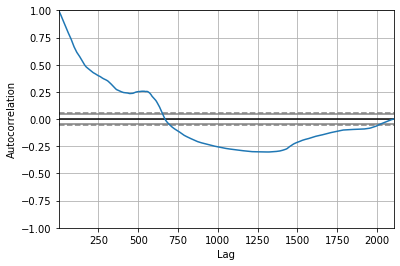

In [16]:
"""
Check if variables are stationary
"""
autocorrelation_plot(btc_df.close)
plt.show()

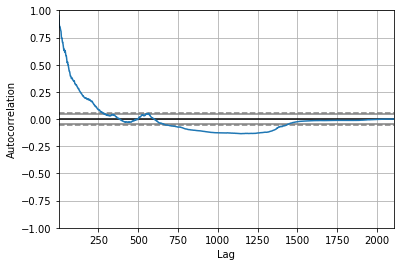

In [17]:
autocorrelation_plot(btc_df.trend)
plt.show()

We want the values we're going to use to be stationary, so close and trend values should be transformed.

## Feature Engineering
<a id='eng'></a>

Financial data is known to perform well when features such as the difference or rate of change are used. Price itself is not stationary or normally distributed so we want a better measure to feed into our model. The percent change values are also better log-scaled since they are bounded at -1.0.

In [18]:
btc_df['log_returns'] = np.log(btc_df['close'].pct_change() + 1)
btc_df['log_trend_chg'] = np.log(btc_df['trend'].pct_change() + 1)
btc_df.tail()

,open,high,low,close,volume,marketcap,trend,log_returns,log_trend_chg
date,,,,,,,,,
2019-10-02,8344.21,8393.04,8227.70,8393.04,13125712443,150823797662,6.115520,0.005946,-0.113329
2019-10-03,8390.77,8414.23,8146.44,8259.99,13668823409,148448162840,6.360141,-0.015979,0.039221
2019-10-04,8259.49,8260.06,8151.24,8205.94,13139456229,147491804056,5.626278,-0.006565,-0.122602
2019-10-05,8210.15,8215.53,8071.12,8151.50,12200497197,146529229668,5.137037,-0.006656,-0.090972
2019-10-06,8149.88,8161.41,7958.85,7988.16,13160830305,143607672862,5.381658,-0.020242,0.046520


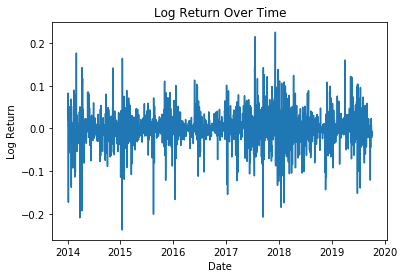

In [19]:
plt.plot(btc_df.log_returns)
plt.title('Log Return Over Time')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

D:\Programs\Anaconda\envs\capstone\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Programs\Anaconda\envs\capstone\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


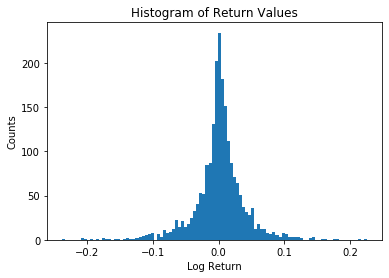

In [20]:
plt.hist(btc_df.log_returns, bins=100)
plt.title('Histogram of Return Values')
plt.xlabel('Log Return')
plt.ylabel('Counts')
plt.show()

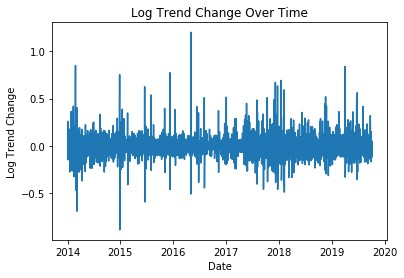

In [21]:
plt.plot(btc_df.log_trend_chg)
plt.title('Log Trend Change Over Time')
plt.xlabel('Date')
plt.ylabel('Log Trend Change')
plt.show()

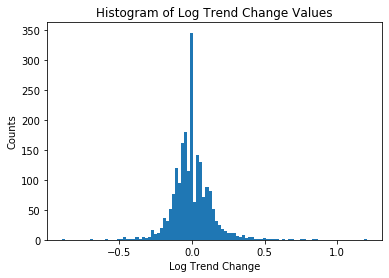

In [22]:
plt.hist(btc_df.log_trend_chg, bins=100)
plt.title('Histogram of Log Trend Change Values')
plt.xlabel('Log Trend Change')
plt.ylabel('Counts')
plt.show()

The difference values are also better suited to be log transformed, since they are bounded at -1.0.

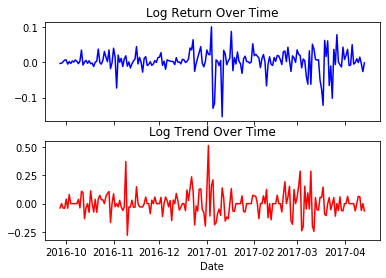

In [23]:
fig, axs = plt.subplots(2, sharex=True)
axs[0].plot(btc_df.log_returns[1000:1200], 'b', label='Log Return')
axs[0].set_title('Log Return Over Time')
axs[1].plot(btc_df.log_trend_chg[1000:1200], 'r', label='Log Trend')
axs[1].set_title('Log Trend Over Time')
plt.xlabel('Date')
plt.show()

Although the variables are not strongly correlated, we can see that when the trend value increases the return values seem to be more volatile. Although the trend metric has no distinction between "good" or "bad" trends and therefore little predictive power in terms of determining positive or negative changes in return value, the trend data may help learn about periods of volatility. 

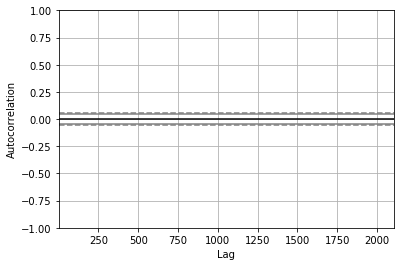

In [24]:
"""
Check autocorrelation for transformed values
"""
autocorrelation_plot(btc_df.log_returns)
plt.show()

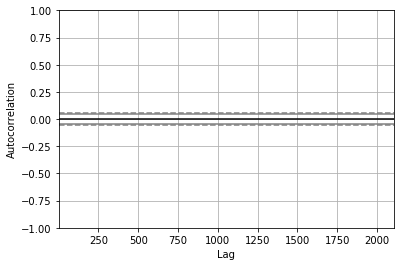

In [25]:
autocorrelation_plot(btc_df.log_trend_chg)
plt.show()

In [26]:
btc_df[['log_trend_chg', 'log_returns']].corr()

,log_trend_chg,log_returns
log_trend_chg,1.00000,-0.00668
log_returns,-0.00668,1.00000


### Save DataFrame of log return and log trend values

In [28]:
"""
Save to csv and drop first row since they are NaN from pct_change
"""
btc_df[['log_trend_chg', 'log_returns']][1:].to_csv('../data/processed/price_trend_data.csv')